In [13]:
# Import statements
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import acf
import epyestim.covid19 as c19
from epyestim.distributions import discretise_gamma

In [14]:
# Read in processed datasets
wide_data_total = pd.read_csv('Data/wide_total.csv')
wide_data_total['date'] = pd.to_datetime(wide_data_total['date'])
wide_data_total.set_index('date',inplace=True)
weekly_counts_total = pd.read_csv('Data/weekly_total.csv')
weekly_counts_total['date'] = pd.to_datetime(weekly_counts_total['date'])
weekly_counts_total.set_index('date',inplace=True)
cases = pd.read_csv('Data/cases_total.csv')
cases['date'] = pd.to_datetime(cases['date'])
cases.set_index('date',inplace=True)
npis = pd.read_csv('Data/ltla_to_nhs.csv')

cases_region = pd.merge(cases.reset_index(), npis, left_on='area_name', right_on='ltla20nm')
cases_region.drop(columns=['ltla20nm','area_code','area_name','Unnamed: 0'],inplace=True)
cases_region = cases_region.groupby(['date','region']).sum().reset_index().set_index('date')

In [35]:
# Function to calculate spatial EWS
def calculate_spatial_ews(long_data):
    # rolling = long_data.groupby(['region','date']).rolling(window=window_size,center=False, min_periods=1)
    # variance = rolling.var(1,numeric_only=True)['detrended'].reset_index().drop(columns='level_2').rename(columns={'detrended':'variance'})
    # skew = rolling.skew(1,numeric_only=True)['detrended'].reset_index().drop(columns='level_2').rename(columns={'detrended':'variance'})
    grouped = long_data.groupby(['region','date'])
    variance = grouped.var(1,numeric_only=True)['detrended'].reset_index().rename(columns={'detrended':'variance'}).set_index('date')
    skew = grouped.skew(numeric_only=True)['detrended'].reset_index().rename(columns={'detrended':'skew'}).set_index('date')
    skew.insert(2,'variance',variance['variance'].values)
    ews_data = skew.copy(deep=True)
    return ews_data

# Function to normalise ews data
def calculate_normalised_spatial_ews(ews_data_regional):
    ews_data_regional_norm = ews_data_regional.copy(deep=True)
    for region in np.unique(ews_data_regional_norm['region'].values):
        temp = ews_data_regional_norm[ews_data_regional_norm['region']==region]
        temp.loc[:,'skew']=(temp['skew'] - temp['skew'].expanding().mean())/temp['skew'].expanding().std()
        temp.loc[:,'variance'] =(temp['variance'] - temp['variance'].expanding().mean())/temp['variance'].expanding().std()
        ews_data_regional_norm.loc[ews_data_regional_norm['region']==region,['skew','variance']] = temp
    return ews_data_regional_norm

def long_run_averages(standardised):
    n = len(standardised)
    running_mean = np.zeros(n)
    running_std= np.zeros(n)
    for j in range(n):
        running_mean[j] = np.nanmean(standardised[1:j+1])
        running_std[j] = np.nanstd(standardised[1:j+1])
    return running_std, running_mean

def exceed_threshold_cutoffs(stat_timeseries, transition_dates, ltla):
    std_val = []
    mean_val = []
    prev_date = pd.Timestamp.min
    for date in transition_dates:
        current_timeseries = stat_timeseries[(stat_timeseries['date'] > prev_date) & (stat_timeseries['date'] <= date)]
        running_std, running_mean = long_run_averages(current_timeseries[ltla].values)
        std_val = np.concatenate((std_val,running_std))
        mean_val = np.concatenate((mean_val,running_mean))
        prev_date = date
    # Get indices where stat > mean + 2*sigma and indices where stat < mean - 2*sigma
    stat_timeseries = stat_timeseries[ltla].values
    indices_greater = [ n for n,i in enumerate(range(len(stat_timeseries))) if (stat_timeseries[i])>(mean_val+2*std_val)[i] ]
    indices_smaller =  [ n for n,i in enumerate(range(len(stat_timeseries))) if (stat_timeseries[i])<(mean_val-2*std_val)[i] ]
    all_indices = np.setdiff1d(np.unique(indices_greater + indices_smaller ),[1])    
    return all_indices,mean_val,std_val
    
def loop_EWSs_store_results_cutoffs(ews_dict, nhs_transitions):
    indices_dict = {}
    mean_dict = {}
    std_dict = {}
    for stat in ews_dict.keys():
        indices_dict[stat] = {}
        mean_dict[stat] = {}
        std_dict[stat] = {}
        for nhs in nhs_transitions.keys():
            transition_dates = nhs_transitions[nhs]
            stat_data = ews_dict[stat][nhs].reset_index()
            indices, mean_val, std_val = exceed_threshold_cutoffs(stat_data, transition_dates, nhs)
            indices_dict[stat][nhs] = indices
            mean_dict[stat][nhs] = mean_val
            std_dict[stat][nhs] = std_val
    return indices_dict, mean_dict, std_dict

def exceed_threshold_cutoffs_regional(stat_timeseries, transition_dates, stat):
    std_val = []
    mean_val = []
    prev_date = pd.Timestamp.min
    for date in transition_dates:
        current_timeseries = stat_timeseries[(stat_timeseries['date'] > prev_date) & (stat_timeseries['date'] <= date)]
        running_std, running_mean = long_run_averages(current_timeseries[stat].values)
        std_val = np.concatenate((std_val,running_std))
        mean_val = np.concatenate((mean_val,running_mean))
        prev_date = date
    # Get indices where stat > mean + 2*sigma and indices where stat < mean - 2*sigma
    stat_timeseries = stat_timeseries[stat].values
    indices_greater = [ n for n,i in enumerate(range(len(stat_timeseries))) if (stat_timeseries[i])>(mean_val+2*std_val)[i] ]
    indices_smaller =  [ n for n,i in enumerate(range(len(stat_timeseries))) if (stat_timeseries[i])<(mean_val-2*std_val)[i] ]
    all_indices = np.setdiff1d(np.unique(indices_greater + indices_smaller ),[1])    
    return all_indices,mean_val,std_val

def two_sigma_regional(normalised_df, nhs_transitions):
    indices_dict = {}
    mean_dict = {}
    std_dict = {}
    for col in ['skew','variance']:
        indices_dict[col] = {}
        mean_dict[col] = {}
        std_dict[col] = {}
        for region in np.unique(normalised_df['region'].values):
            stat_data = normalised_df.loc[normalised_df['region']==region,col].reset_index()
            indices, mean_val, std_val = exceed_threshold_cutoffs_regional(stat_data, nhs_transitions[region], col)
            indices_dict[col][region] = indices
            mean_dict[col][region] = mean_val
            std_dict[col][region] = std_val
    return indices_dict, mean_dict, std_dict

# Function to normalise EWS for 2-sigma calculations
def pandas_zscore(dataframe):
    rolling_mean = dataframe.expanding().mean()
    rolling_std = dataframe.expanding().std(ddof=0)
    normalise_stats = (dataframe - rolling_mean)/rolling_std
    return normalise_stats

# Function to calculate EWS on a rolling window for each column
def calculate_ews_rolling(wide_data, window_size):
    ews_data = {}
    acf_data = {}
    rolling = wide_data.rolling(window=window_size,center=False, min_periods=1)
    # variance = (wide_data**2).rolling(window=window_size,center=False, min_periods=1).mean()
    variance = rolling.var()
    coefficient_of_variation = rolling.std() / rolling.mean()
    iod = rolling.var() / rolling.mean()
    skew = rolling.skew()
    kurt = rolling.kurt()
    first_diff = rolling.var().diff(axis=0)
    ews_data['variance'] = variance
    ews_data['cov'] = coefficient_of_variation
    ews_data['skew'] = skew
    ews_data['kurt'] = kurt
    ews_data['iod'] = iod
    ews_data['first diff'] = first_diff
    for col in wide_data.columns:
        rolled_group = wide_data[col].rolling(window=window_size, min_periods=1)
        autocorrelation = rolled_group.apply(lambda x: acf(x, nlags=1)[1] if len(x) > 1 else np.nan)
        acf_data[col] = autocorrelation
    ews_data['acf'] = pd.DataFrame.from_dict(acf_data)
    normalised_ews_data = {}
    for ews in ews_data.keys():
        normalised_ews_data[ews] = pandas_zscore(ews_data[ews])
    return ews_data, normalised_ews_data

In [80]:
# areas = np.unique(cases['area_name'].values)
def find_critical_transitions(timeseries):
    fitted_r = c19.r_covid(timeseries,smoothing_window=35,gt_distribution=discretise_gamma(8.5,0.62))
    crossing_days = []
    values = fitted_r['R_mean'].values
    dates = timeseries.reset_index()['date'].values
    # Loop through the values to find transitions through 1
    for i in range(len(values) - 1):
        if (values[i] < 1 and values[i+1] > 1) or (values[i] > 1 and values[i+1] < 1):
            crossing_days.append(dates[i+1])
    crossing_days.append(pd.Timestamp.max)
    return crossing_days

areas = np.unique(cases_region['region'].values)
nhs_transitions = {}
for area in areas:
    timeseries = cases_region[cases_region['region']==area]['value']
    nhs_transitions[area] = find_critical_transitions(timeseries)

In [81]:
# Consider spatial EWS across regions
# Group by region and consider spatial skew and variance
spatial_ews = calculate_spatial_ews(weekly_counts_total)
normalised_spatial_ews = calculate_normalised_spatial_ews(spatial_ews)
indices_regional, means_regional, std_regional = two_sigma_regional(normalised_spatial_ews,nhs_transitions)

# Consider temporal EWS across regions
# Group by region and consider temporal variance and first difference
# wide_regional = 
# ews_7total, norm_ews_7total = calculate_ews_rolling(wide_data_total,window_size=7)
# indices_regional, means_regional, std_regional = two_sigma_regional(normalised_spatial_ews,nhs_transitions)

/tmp/ipykernel_200434/961960891.py:28: RuntimeWarning: Mean of empty slice
  running_mean[j] = np.nanmean(standardised[1:j+1])
/home/jlooker/anaconda3/envs/mathsysbase/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_200434/961960891.py:28: RuntimeWarning: Mean of empty slice
  running_mean[j] = np.nanmean(standardised[1:j+1])
/home/jlooker/anaconda3/envs/mathsysbase/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_200434/961960891.py:28: RuntimeWarning: Mean of empty slice
  running_mean[j] = np.nanmean(standardised[1:j+1])
/home/jlooker/anaconda3/envs/mathsysbase/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=d

In [18]:
cases_backup = cases_region.copy(deep=True)

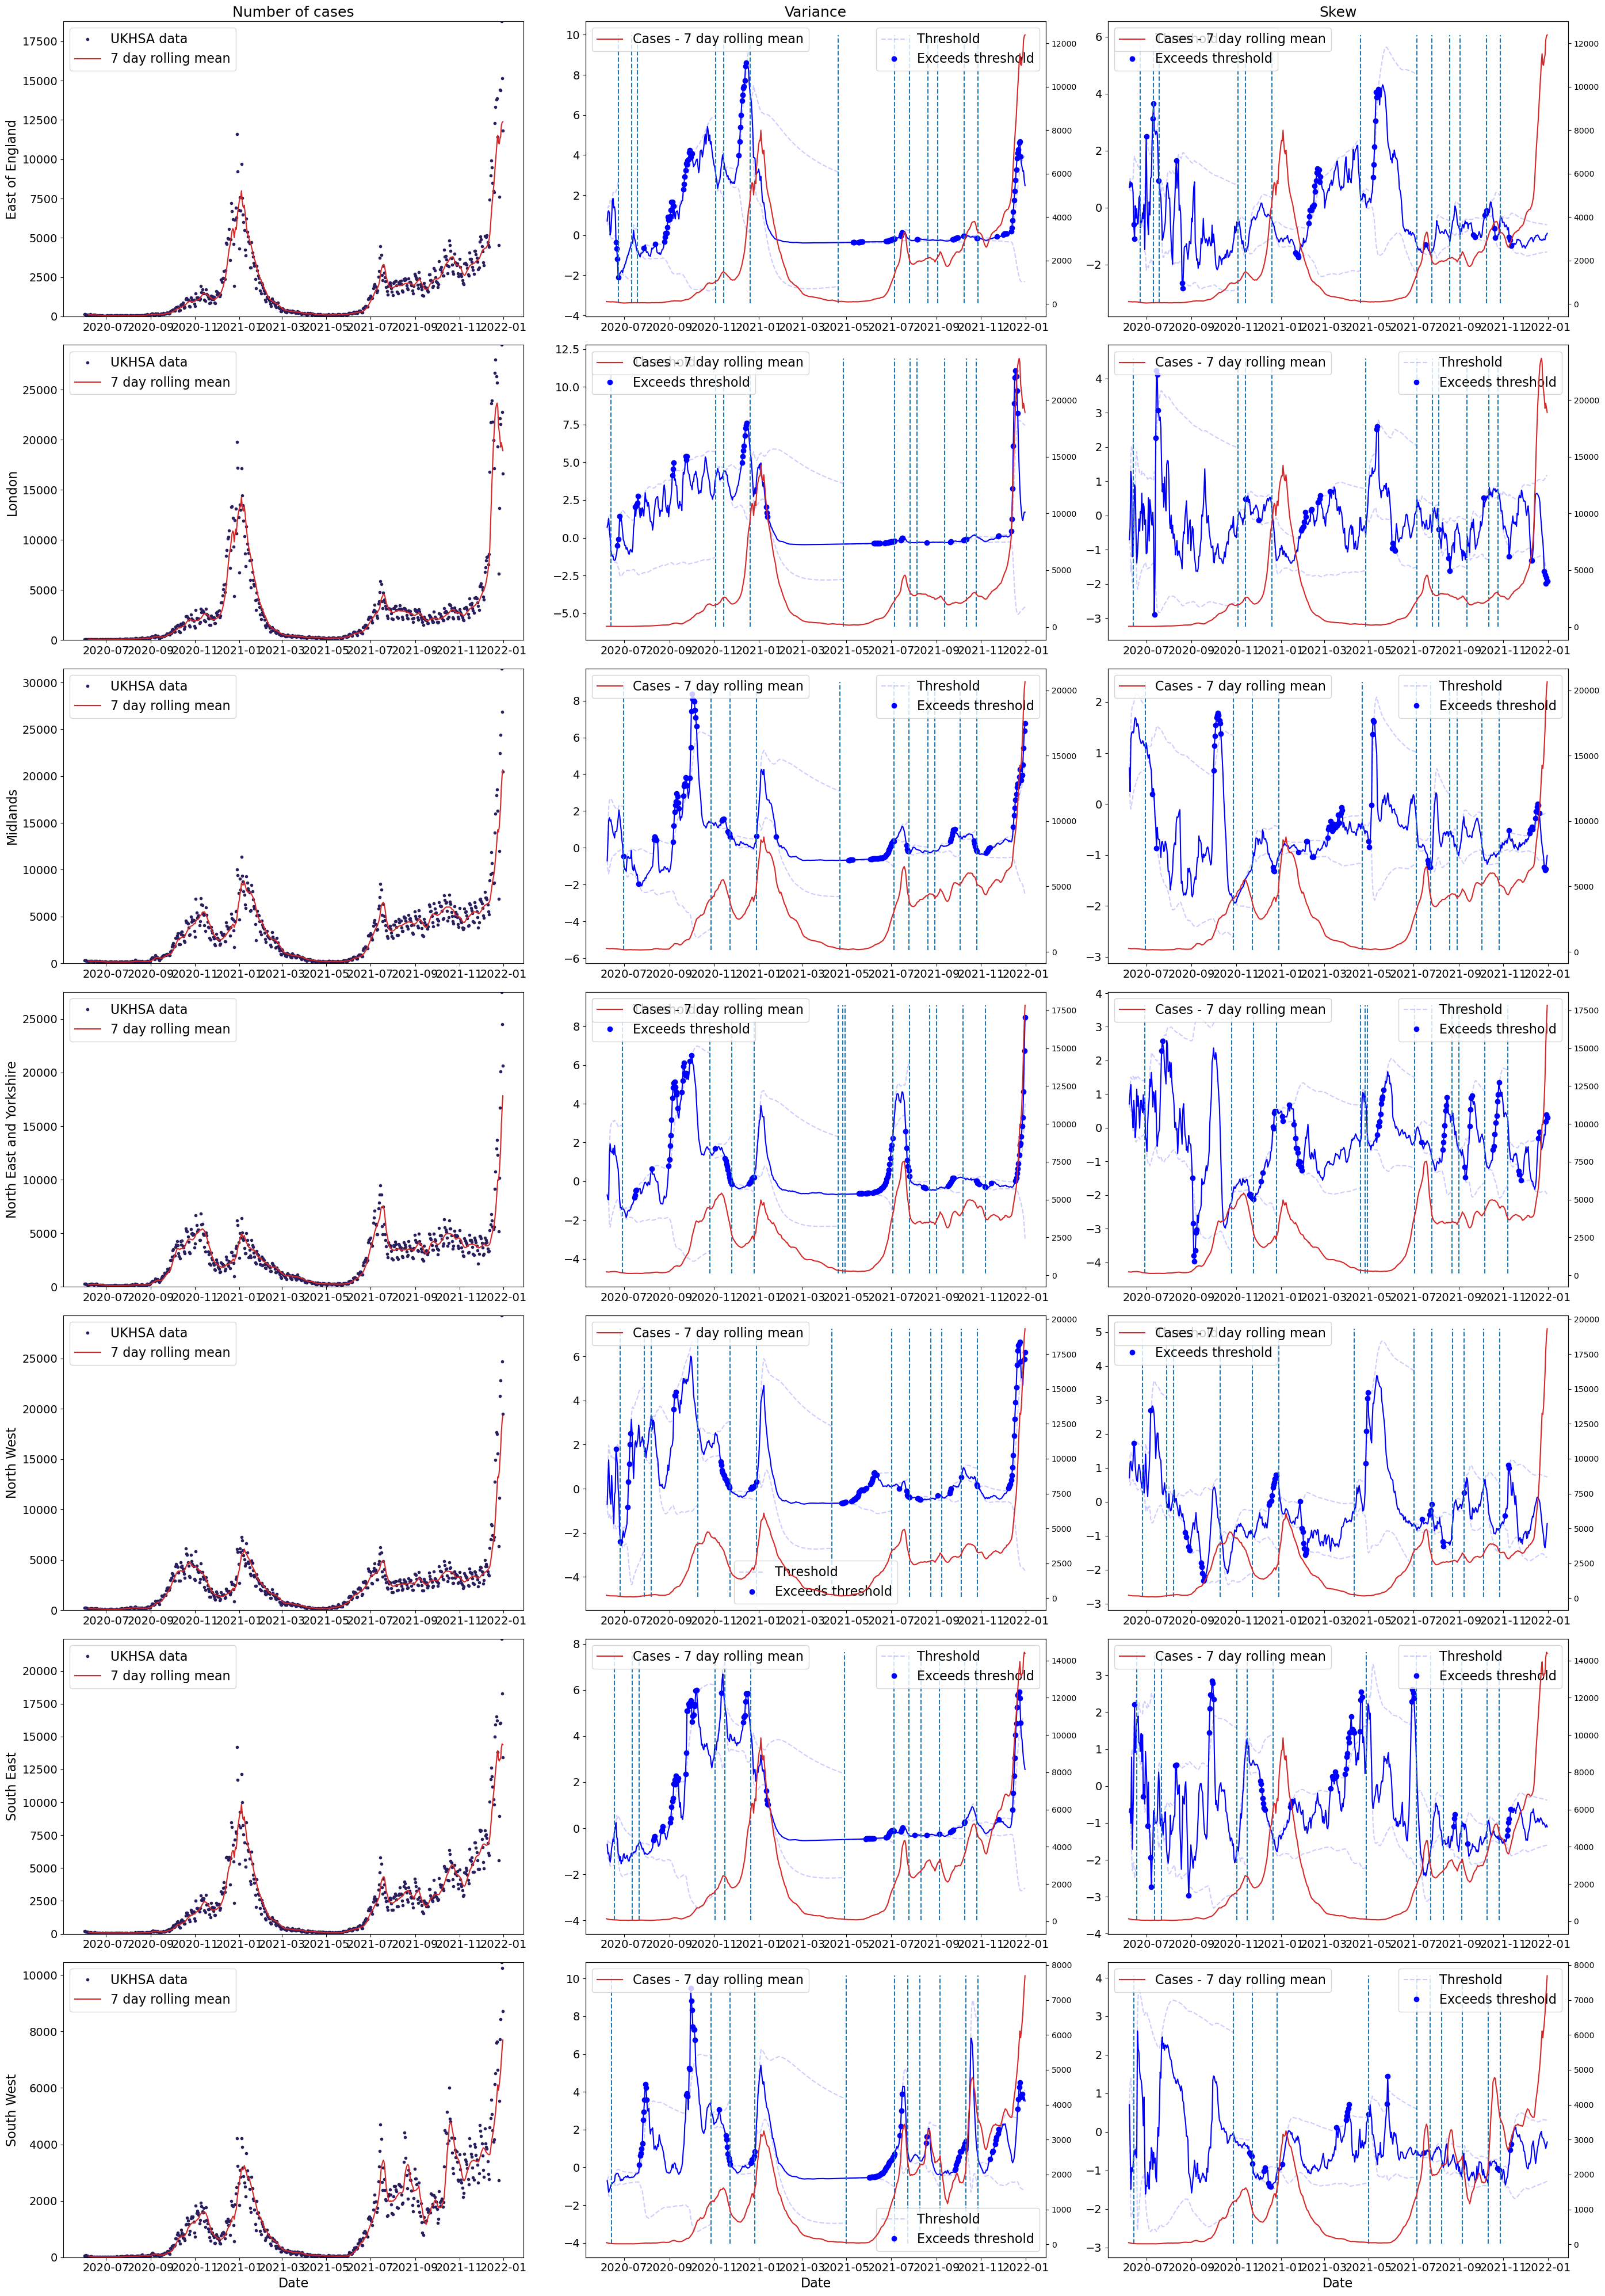

In [82]:
# Plot spatial EWS for each group
num_regions = len(np.unique(normalised_spatial_ews['region'].values))
regions = np.unique(normalised_spatial_ews['region'].values)
fig, axs = plt.subplots(nrows=num_regions,ncols=3,figsize=(28,40))
for row, region in enumerate(regions):
    for col, signal in enumerate(['incidence','variance','skew']):
        counts =  cases_region[cases_region['region']==region].groupby(['date','region']).sum(numeric_only=True)['value'].reset_index()
        counts['rolling'] = counts['value'].rolling(7).mean()
        if signal == 'incidence':
            ax = axs[row, col]
            ax.plot(counts['date'],counts['value'],".",label="UKHSA data",color='#2A1E5C')
            ax.plot(counts['date'],counts['rolling'],label="7 day rolling mean",color='#D62828')
            ax.legend(fontsize=16)
            ax.xaxis.label.set_visible(False)
            ax.set_ylim([0,np.max(counts['value'].values)+1])
        else:
            ax = axs[row, col]
            ax2 = ax.twinx()
            ax2.plot(counts['date'],counts['rolling'],color='#D62828',label='Cases - 7 day rolling mean')
            ax2.legend(fontsize=16)
            signal_data = normalised_spatial_ews[normalised_spatial_ews['region'] == region][signal]
            std_val = std_regional[signal][region]
            mean_val = means_regional[signal][region]
            signal_data = signal_data.reset_index()
            ax.plot(signal_data['date'],signal_data[signal],color='blue')
            ax.plot(signal_data['date'],mean_val+2*std_val,color='blue',alpha=0.2,linestyle='--',label='Threshold')
            ax.plot(signal_data['date'],mean_val-2*std_val,color='blue',alpha=0.2,linestyle='--')
            ax.plot(signal_data['date'][indices_regional[signal][region]],signal_data[signal][indices_regional[signal][region]],'o',color='blue',label='Exceeds threshold')
            ax.legend(fontsize=16)
            ax.vlines(x=nhs_transitions[region][:-1],ymin=ax.get_ylim()[0],ymax=ax.get_ylim()[1],linestyle='--')
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
        if col == 0:
            axs[row,col].set_ylabel(region,fontsize=16)

titles = ['Number of cases','Variance','Skew']
for i in range(3):
    axs[0,i].set_title(titles[i],fontsize=18)
    axs[len(axs)-1,i].set_xlabel("Date",fontsize=16)
    axs[len(axs)-1,i].xaxis.label.set_visible(True)

plt.tight_layout()
plt.savefig("Figures/spatial2sigmaregional.pdf",dpi=2400,bbox_inches='tight')
plt.show()

In [83]:
# Hospitalisations
wide_data_hosp_cases = pd.read_csv('Data/wide_hosp_cases.csv')
wide_data_hosp_cases['date'] = pd.to_datetime(wide_data_hosp_cases['date'])
wide_data_hosp_cases.set_index('date',inplace=True)
wide_data_hosp_inc = pd.read_csv('Data/wide_hosp_inc.csv')
wide_data_hosp_inc['date'] = pd.to_datetime(wide_data_hosp_inc['date'])
wide_data_hosp_inc.set_index('date',inplace=True)
hospcases_weekly = pd.read_csv('Data/long_hosp_cases.csv')
hosps_weekly = pd.read_csv('Data/long_hosp_inc.csv')

In [84]:
ews_7total_inc, norm_ews_7total_inc = calculate_ews_rolling(wide_data_hosp_inc,window_size=7)
ews_14total_inc, norm_ews_14total_inc = calculate_ews_rolling(wide_data_hosp_inc,window_size=14)
ews_7total_hosp, norm_ews_7total_hosp = calculate_ews_rolling(wide_data_hosp_inc,window_size=7)
ews_14total_hosp, norm_ews_14total_hosp = calculate_ews_rolling(wide_data_hosp_inc,window_size=14)

indices_regional_inc, means_regional_inc, std_regional_inc = loop_EWSs_store_results_cutoffs(norm_ews_14total_inc,nhs_transitions)
indices_regional_hosp, means_regional_hosp, std_regional_hosp = loop_EWSs_store_results_cutoffs(norm_ews_7total_hosp,nhs_transitions)

/tmp/ipykernel_200434/961960891.py:28: RuntimeWarning: Mean of empty slice
  running_mean[j] = np.nanmean(standardised[1:j+1])
/home/jlooker/anaconda3/envs/mathsysbase/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_200434/961960891.py:28: RuntimeWarning: Mean of empty slice
  running_mean[j] = np.nanmean(standardised[1:j+1])
/home/jlooker/anaconda3/envs/mathsysbase/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_200434/961960891.py:28: RuntimeWarning: Mean of empty slice
  running_mean[j] = np.nanmean(standardised[1:j+1])
/home/jlooker/anaconda3/envs/mathsysbase/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=d

In [85]:
# Get detect indices for timeline
from operator import itemgetter

def detect(arr):
    if len(arr) < 3:
        return []

    values = []
    i = 0
    while i < len(arr) - 2:
        if arr[i] + 1 == arr[i + 1] and arr[i + 1] + 1 == arr[i + 2]:
            values.append(arr[i + 2])
            # Skip to the end of this sequence of consecutive numbers
            while i + 2 < len(arr) - 1 and arr[i + 2] + 1 == arr[i + 3]:
                i += 1
        i += 1
    
    return values

In [86]:
detect_inc = {}
detect_hosp = {}
detect_cases = {}
for signal in indices_regional_inc.keys():
    detect_inc[signal] = {}
    detect_hosp[signal] ={}
    for area in indices_regional_inc[signal].keys():
        detect_inc[signal][area] = detect(indices_regional_inc[signal][area])
        detect_hosp[signal][area] = detect(indices_regional_hosp[signal][area])

for signal in indices_regional.keys():
    detect_cases[signal] ={}
    for area in indices_regional[signal].keys():
        detect_cases[signal][area] = detect(indices_regional[signal][area])

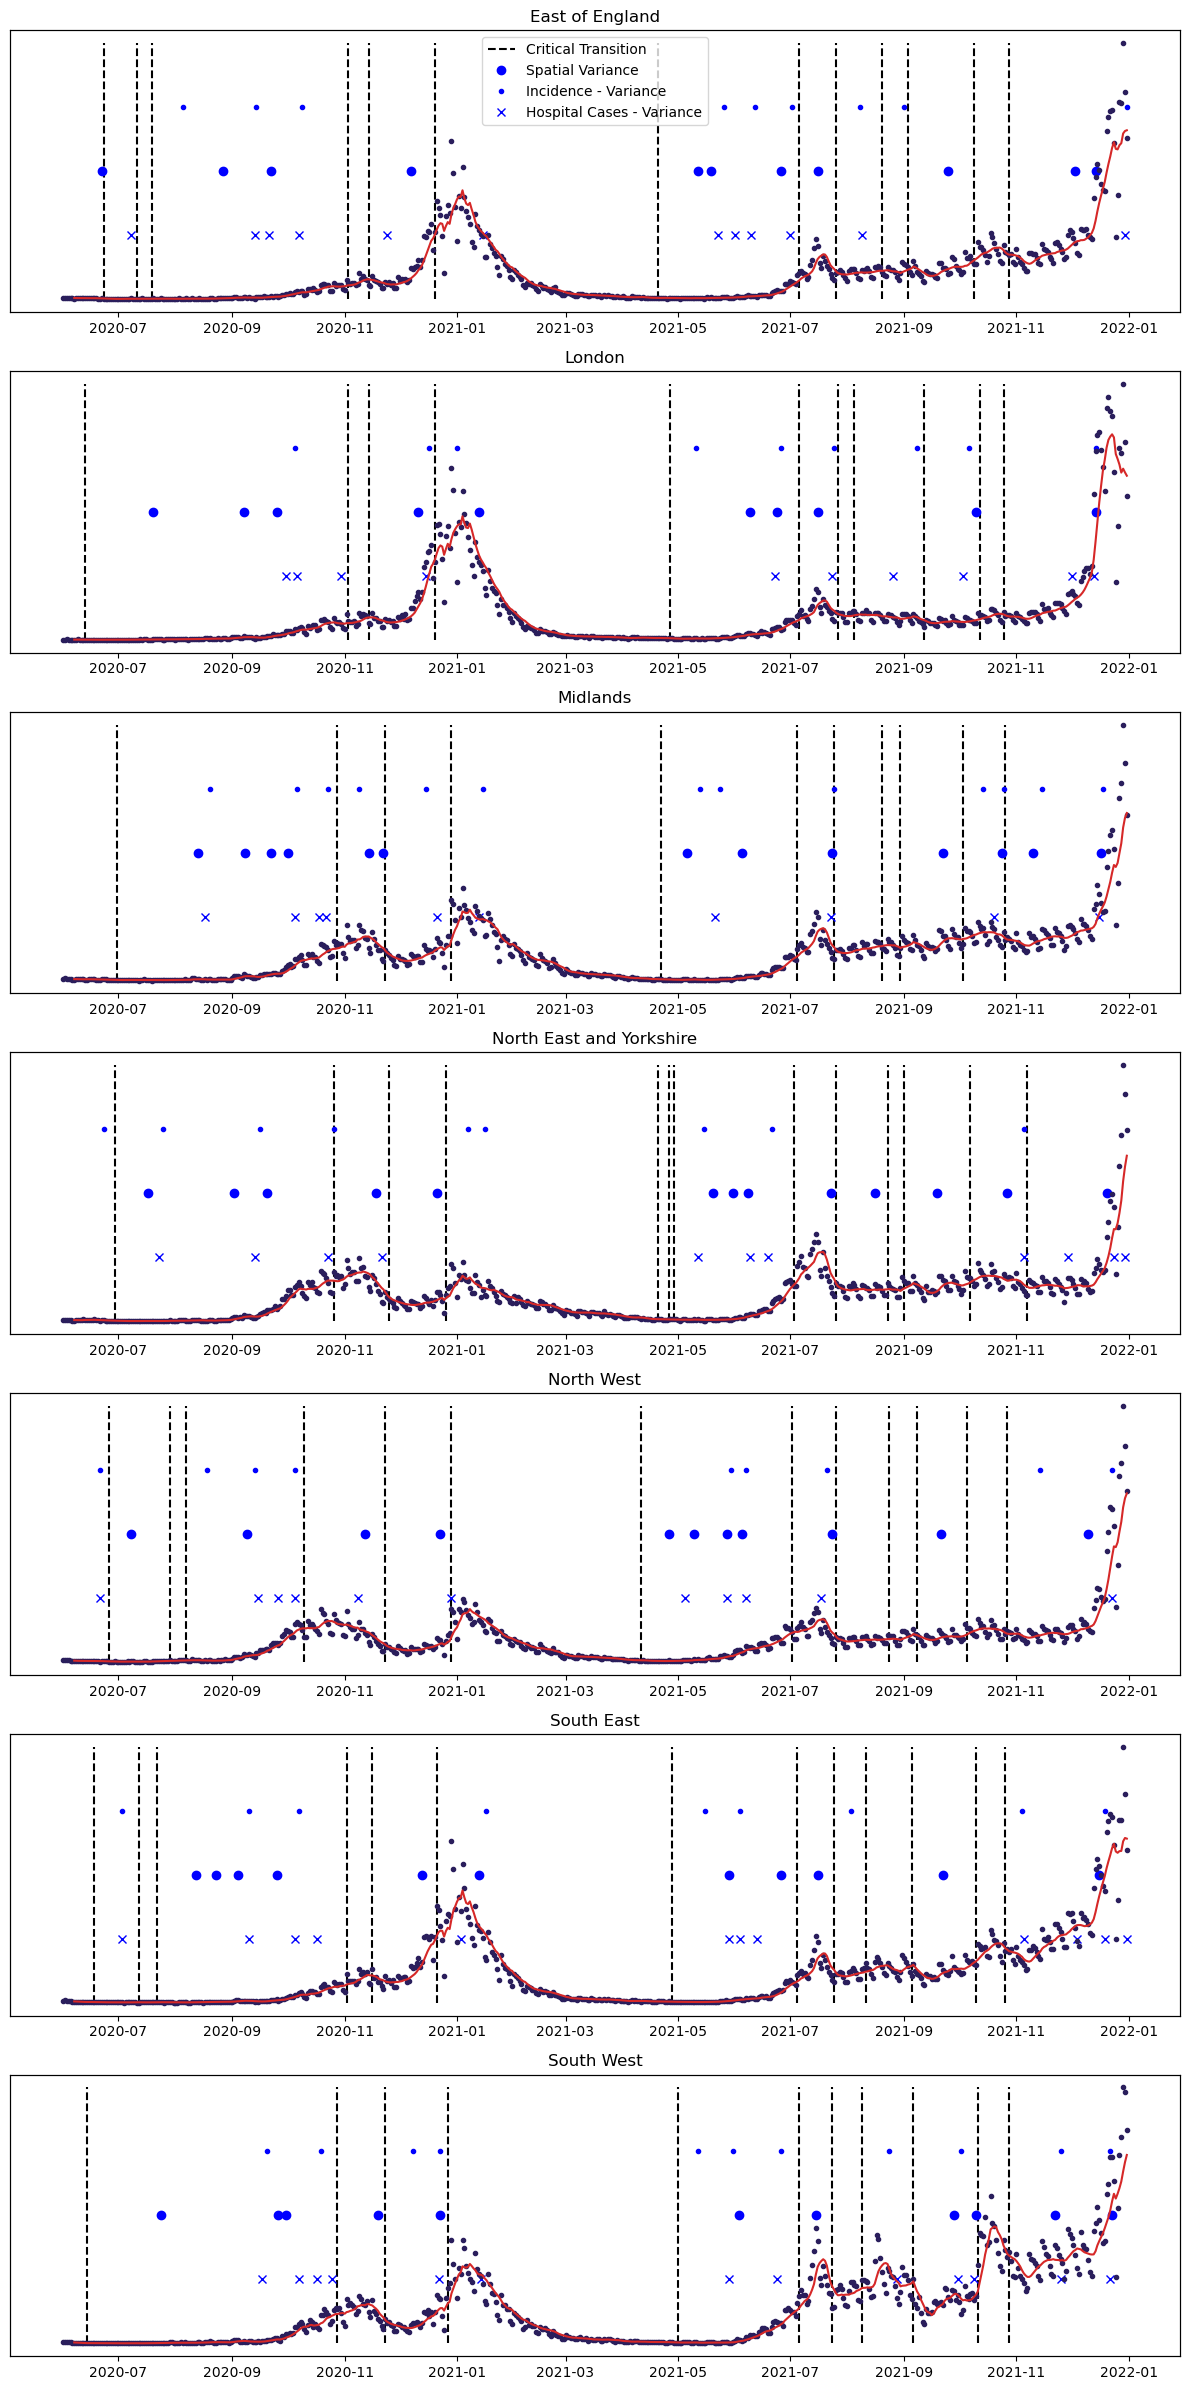

In [106]:
fig, axs = plt.subplots(7,1,figsize=(12,24))
for i, region in enumerate(nhs_transitions.keys()):
    axs[i].vlines(x=nhs_transitions[region][:-1],ymin=-1,ymax=1,color='k',label='Critical Transition',linestyle='--')
    signal_data = normalised_spatial_ews[normalised_spatial_ews['region'] == region]['variance']
    signal_data = signal_data.reset_index()
    xs = signal_data['date'][detect_cases['variance'][region]]
    axs[i].plot(xs,[0]*len(xs),'o',color='blue',label='Spatial Variance')
    
    signal_data = norm_ews_14total_inc['variance'][region]
    signal_data = signal_data.reset_index()
    xs = signal_data['date'][detect_inc['variance'][region]]
    axs[i].plot(xs,[0.5]*len(xs),'.',color='blue',label='Incidence - Variance')

    signal_data = norm_ews_7total_hosp['variance'][region]
    signal_data = signal_data.reset_index()
    xs = signal_data['date'][detect_hosp['variance'][region]]
    axs[i].plot(xs,[-0.5]*len(xs),'x',color='blue',label='Hospital Cases - Variance')

    ax = axs[i].twinx()
    counts =  cases_region[cases_region['region']==region].groupby(['date','region']).sum(numeric_only=True)['value'].reset_index()
    counts['rolling'] = counts['value'].rolling(7).mean()
    ax.plot(counts['date'],counts['value'],".",label="UKHSA data",color='#2A1E5C')
    ax.plot(counts['date'],counts['rolling'],label="7 day rolling mean",color='#D62828')
    ax.set_ylim()
    axs[i].set_title(region)
    ax.get_yaxis().set_ticks([])
    axs[i].get_yaxis().set_ticks([])

axs[0].legend()
plt.tight_layout()
plt.savefig('Figures/hosp_timeline.pdf')
plt.show()